# Libraries

In [1]:
# !'/users/PCS0229/imankhazrak/miniconda3/envs/ddpm_pytorch/bin/python' -m pip install tensorflow
# !'/users/PCS0229/imankhazrak/miniconda3/envs/ddpm_pytorch/bin/python' -m pip install matplotlib
# !'/users/PCS0229/imankhazrak/miniconda3/envs/ddpm_pytorch/bin/python' -m pip install scikit-learn



In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras import layers, models
from keras import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout


from VGG16_models import preprocess_grayscale_to_rgb, VGG_model, VGG_imagenet, MobileNet_imagenet, data_generator, evaluate_validation_set, evaluate_test_set, prepare_train_val_data
from plots import plot_confusion_matrix, plot_training_history, plot_training_history2


path_dir = os.getcwd()
np.random.seed(123)
tf.random.set_seed(123)

2024-04-18 22:31:16.717628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 22:31:18.650664: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Pre-trained VGG16- 2 classes 
Classes: pneumonia and normal

## Baseline model

### Fitting model

In [3]:

model_2class = VGG_imagenet((224, 224, 3), num_classes=2)
model_2class.summary()


2024-04-18 22:31:22.710883: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ grayscale_input (InputLayer)    │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,407,874 (154.14 MB)

 Trainable params: 25,693,186 (98.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [4]:
dataset_dir = f'{path_dir}/DataDDPM/Original'
class_labels = sorted(os.listdir(dataset_dir))
class_labels = class_labels[1:3]
train_gen, val_gen, X_train, X_val, batch_size = prepare_train_val_data(dataset_dir, class_labels)


Epoch 1/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 956ms/step - accuracy: 0.4496 - loss: 11.0142 - val_accuracy: 0.6719 - val_loss: 1.4460
Epoch 2/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 866ms/step - accuracy: 0.7224 - loss: 1.2354 - val_accuracy: 0.7500 - val_loss: 0.7657
Epoch 3/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 867ms/step - accuracy: 0.8736 - loss: 0.3514 - val_accuracy: 0.9375 - val_loss: 0.3737
Epoch 4/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 899ms/step - accuracy: 0.9424 - loss: 0.1497 - val_accuracy: 0.9062 - val_loss: 0.1805


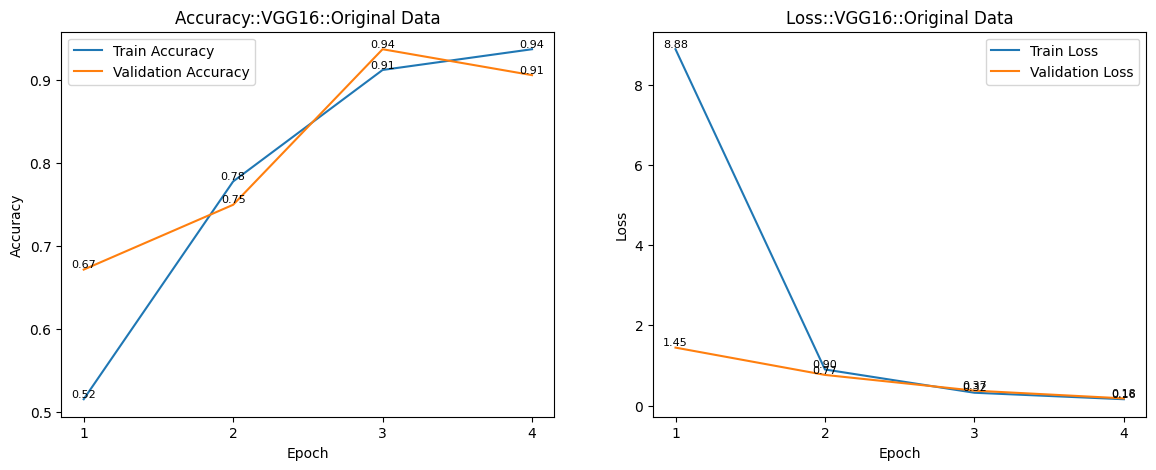

In [5]:
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

history_2class = model_2class.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=4
)

#### Plot Acuuracy and Loss
title= "Original Data"
model_name= "VGG16"
plot_training_history(history_2class, title, model_name,figsize=(14, 5))

### Prediction: Validation set


Confusion matrix, without normalization
[[34  5]
 [ 3 38]]


<Figure size 640x480 with 0 Axes>

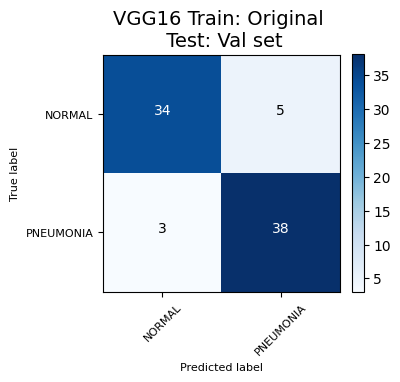

              precision    recall  f1-score   support

      NORMAL       0.92      0.87      0.89        39
   PNEUMONIA       0.88      0.93      0.90        41

    accuracy                           0.90        80
   macro avg       0.90      0.90      0.90        80
weighted avg       0.90      0.90      0.90        80

Binary Classification:
Accuracy: 0.9
Recall: 0.926829268292683
F1 Score: 0.9047619047619048


In [6]:
title = "VGG16 Train: Original \n Test: Val set"

evaluate_validation_set(val_gen, model_2class, X_val, class_labels, plot_confusion_matrix, title)


### Prediction: Test set

Confusion matrix, without normalization
[[1352  230]
 [  54 1546]]


<Figure size 640x480 with 0 Axes>

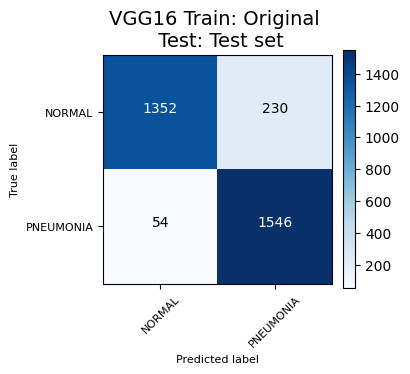

              precision    recall  f1-score   support

      NORMAL       0.96      0.85      0.90      1582
   PNEUMONIA       0.87      0.97      0.92      1600

    accuracy                           0.91      3182
   macro avg       0.92      0.91      0.91      3182
weighted avg       0.92      0.91      0.91      3182

Binary Classification:
Accuracy: 0.9107479572595851
Recall: 0.96625
F1 Score: 0.9158767772511849


In [7]:
dataset_dir = f'{path_dir}/DataDDPM/Test'
title = "VGG16 Train: Original \n Test: Test set"

evaluate_test_set(dataset_dir, model_2class, batch_size, data_generator, plot_confusion_matrix, class_labels, title)


### Prediction: DDPM Generated

Confusion matrix, without normalization
[[ 30 170]
 [  0 200]]


<Figure size 640x480 with 0 Axes>

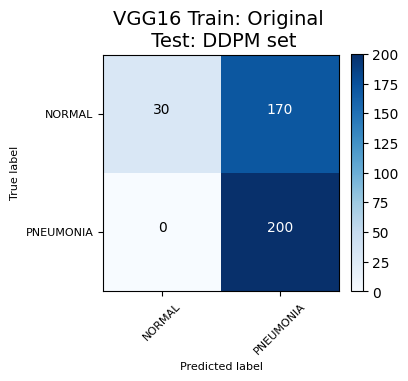

              precision    recall  f1-score   support

      NORMAL       1.00      0.15      0.26       200
   PNEUMONIA       0.54      1.00      0.70       200

    accuracy                           0.57       400
   macro avg       0.77      0.57      0.48       400
weighted avg       0.77      0.57      0.48       400

Binary Classification:
Accuracy: 0.575
Recall: 1.0
F1 Score: 0.7017543859649122


In [8]:
dataset_dir = f'{path_dir}/DataDDPM/Generated'
title = "VGG16 Train: Original \n Test: DDPM set"

evaluate_test_set(dataset_dir, model_2class, batch_size, data_generator, plot_confusion_matrix, class_labels, title)


### Prediction: GANs Generated

Confusion matrix, without normalization
[[  1  99]
 [  0 100]]


<Figure size 640x480 with 0 Axes>

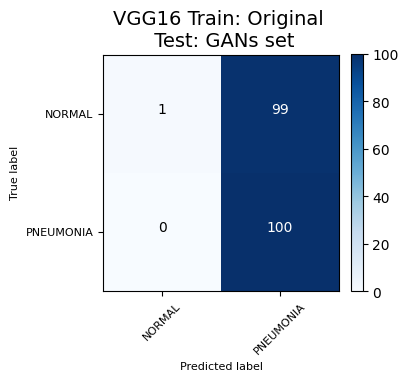

              precision    recall  f1-score   support

      NORMAL       1.00      0.01      0.02       100
   PNEUMONIA       0.50      1.00      0.67       100

    accuracy                           0.51       200
   macro avg       0.75      0.51      0.34       200
weighted avg       0.75      0.51      0.34       200

Binary Classification:
Accuracy: 0.505
Recall: 1.0
F1 Score: 0.6688963210702341


In [9]:
dataset_dir = f'{path_dir}/DataGANS/Generated'
title = "VGG16 Train: Original \n Test: GANs set"

evaluate_test_set(dataset_dir, model_2class, batch_size, data_generator, plot_confusion_matrix, class_labels, title)


## Using DDPM generated data

In [10]:
dataset_dir_mixed = f'{path_dir}/DataDDPM/Mixed'
train_gen, val_gen, X_train, X_val, batch_size = prepare_train_val_data(dataset_dir_mixed, class_labels)


In [11]:
model2_2class = VGG_imagenet((224, 224, 3), num_classes=2)
model2_2class.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ grayscale_input (InputLayer)    │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,407,874 (154.14 MB)

 Trainable params: 25,693,186 (98.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Fitting model

Epoch 1/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 955ms/step - accuracy: 0.7928 - loss: 1.9262 - val_accuracy: 0.8125 - val_loss: 0.7431
Epoch 2/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 930ms/step - accuracy: 0.9301 - loss: 0.2881 - val_accuracy: 0.8938 - val_loss: 0.4511
Epoch 3/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 932ms/step - accuracy: 0.9659 - loss: 0.1064 - val_accuracy: 0.9875 - val_loss: 0.0264
Epoch 4/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 937ms/step - accuracy: 0.9996 - loss: 0.0031 - val_accuracy: 0.9875 - val_loss: 0.0320


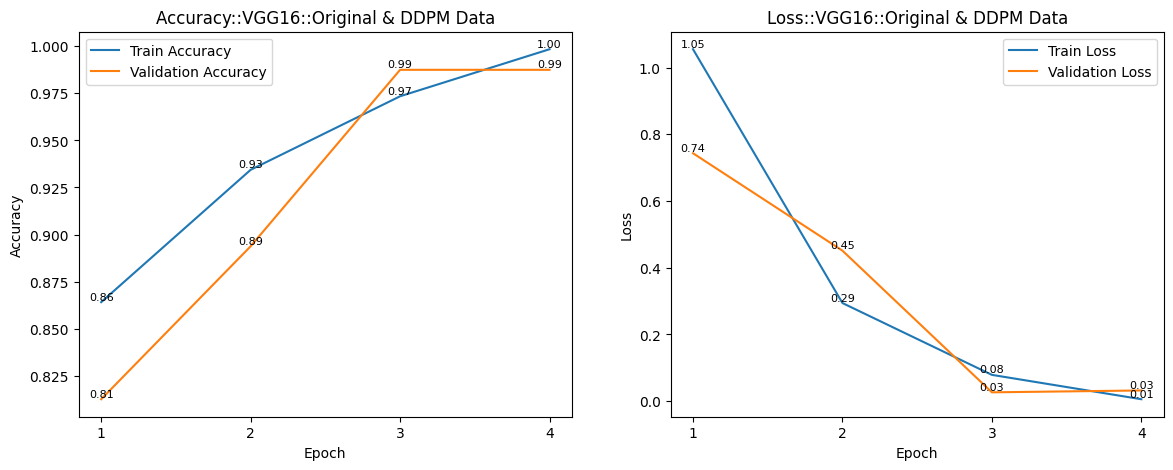

In [12]:
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

history2_2class = model2_2class.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=4
)

title = "Original & DDPM Data"
model_name = "VGG16"
plot_training_history(history2_2class, title, model_name, figsize=(14, 5))


### Prediction: Validation set

Confusion matrix, without normalization
[[90  1]
 [ 0 69]]


<Figure size 640x480 with 0 Axes>

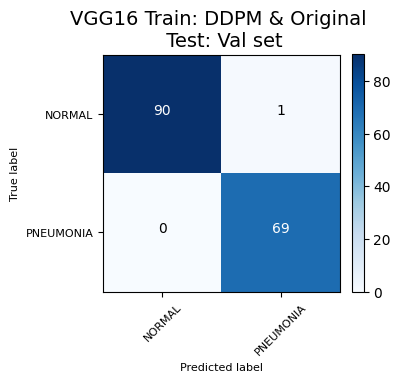

              precision    recall  f1-score   support

      NORMAL       1.00      0.99      0.99        91
   PNEUMONIA       0.99      1.00      0.99        69

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

Binary Classification:
Accuracy: 0.99375
Recall: 1.0
F1 Score: 0.9928057553956835


In [13]:
title = "VGG16 Train: DDPM & Original \n Test: Val set"

evaluate_validation_set(val_gen, model2_2class, X_val, class_labels, plot_confusion_matrix, title)


### Prediction: Test set


Confusion matrix, without normalization
[[1407  175]
 [  32 1568]]


<Figure size 640x480 with 0 Axes>

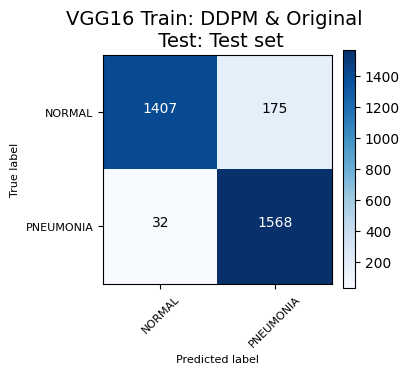

              precision    recall  f1-score   support

      NORMAL       0.98      0.89      0.93      1582
   PNEUMONIA       0.90      0.98      0.94      1600

    accuracy                           0.93      3182
   macro avg       0.94      0.93      0.93      3182
weighted avg       0.94      0.93      0.93      3182

Binary Classification:
Accuracy: 0.9349465744814582
Recall: 0.98
F1 Score: 0.9380795692491773


In [14]:
dataset_dir = f'{path_dir}/DataDDPM/Test'
title = "VGG16 Train: DDPM & Original \n Test: Test set"
evaluate_test_set(dataset_dir, model2_2class, batch_size, data_generator, plot_confusion_matrix, class_labels, title)


## Using GANs generated data

In [15]:
model_gan = VGG_imagenet((224, 224, 3), num_classes=2)
model_gan.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ grayscale_input (InputLayer)    │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,407,874 (154.14 MB)

 Trainable params: 25,693,186 (98.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
dataset_dir_gan = f'{path_dir}/DataGANS/Mixed'
class_labels = sorted(os.listdir(dataset_dir_gan))
train_gen, val_gen, X_train, X_val, batch_size = prepare_train_val_data(dataset_dir_gan, class_labels)


### Fitting model

Epoch 1/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 934ms/step - accuracy: 0.5350 - loss: 7.4676 - val_accuracy: 0.5208 - val_loss: 0.7295
Epoch 2/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 883ms/step - accuracy: 0.7656 - loss: 0.4323 - val_accuracy: 0.8636 - val_loss: 0.3159
Epoch 3/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 885ms/step - accuracy: 0.9212 - loss: 0.2057 - val_accuracy: 0.9091 - val_loss: 0.2691
Epoch 4/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 887ms/step - accuracy: 0.9758 - loss: 0.1112 - val_accuracy: 0.8977 - val_loss: 0.2547


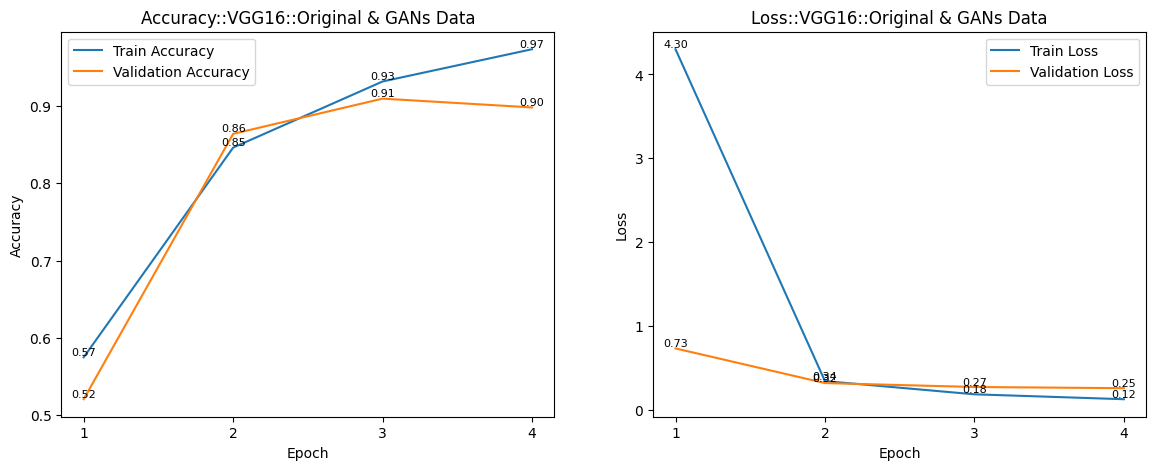

In [17]:
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

history_gan = model_gan.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=4
)

title = "Original & GANs Data"
model_name = "VGG16"
plot_training_history(history_gan, title, model_name, figsize=(14, 5))

### Prediction: Validation set

Confusion matrix, without normalization
[[50  5]
 [ 5 60]]


<Figure size 640x480 with 0 Axes>

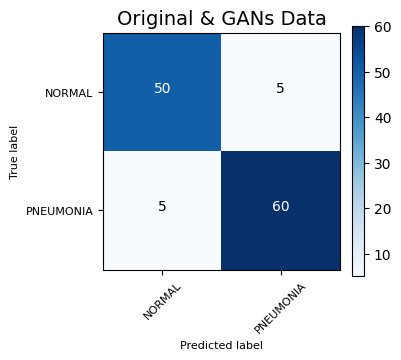

              precision    recall  f1-score   support

      NORMAL       0.91      0.91      0.91        55
   PNEUMONIA       0.92      0.92      0.92        65

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.92      0.92       120

Binary Classification:
Accuracy: 0.9166666666666666
Recall: 0.9230769230769231
F1 Score: 0.9230769230769231


In [18]:
tilte = "VGG16 Train: GANs & Original \n Test: Val set"
evaluate_validation_set(val_gen, model_gan, X_val, class_labels, plot_confusion_matrix, title)


### Prediction: Test set

Confusion matrix, without normalization
[[1519   63]
 [ 150 1450]]


<Figure size 640x480 with 0 Axes>

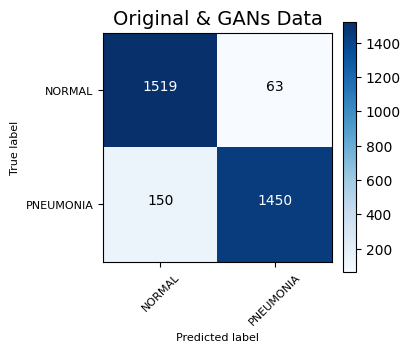

              precision    recall  f1-score   support

      NORMAL       0.91      0.96      0.93      1582
   PNEUMONIA       0.96      0.91      0.93      1600

    accuracy                           0.93      3182
   macro avg       0.93      0.93      0.93      3182
weighted avg       0.93      0.93      0.93      3182

Binary Classification:
Accuracy: 0.9330609679446888
Recall: 0.90625
F1 Score: 0.9315772566655959


In [19]:
dataset_dir = f'{path_dir}/DataDDPM/Test'

tilte = "VGG16 Train: GANs & Original \n Test: Test set"
evaluate_test_set(dataset_dir, model_gan, batch_size, data_generator, plot_confusion_matrix, class_labels, title)


# CNN Classification- 2 classes

In [6]:
class_labels = ['NORMAL', 'PNEUMONIA']
img_size = 128
batch_size = 32
def split_dataset(ds, train_ratio=0.8, val_ratio=0.2, shuffle=True):
    # Get dataset size
    dataset_size = len(ds)

    # Calculate split sizes
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)

    # Shuffle dataset if required
    if shuffle:
        ds = ds.shuffle(dataset_size)

    # Split dataset
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)

    return train_dataset, val_dataset

In [7]:
import os
import tensorflow as tf

def load_and_filter_images(directory, class_labels, img_size=(128, 128)):
    images = []
    labels = []
    label_map = {class_name: index for index, class_name in enumerate(class_labels)}

    for class_name in class_labels:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img)
            labels.append(label_map[class_name])

    images = np.array(images)
    labels = np.array(labels)
    
    return tf.data.Dataset.from_tensor_slices((images, labels))

In [8]:
# import matplotlib.pyplot as plt
# import numpy as np
# import itertools
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues,
#                           figsize=(4, 4),
#                           title_fontsize=14,  
#                           tick_labelsize=8,
#                           colorbar_size={'shrink': 0.75, 'aspect': 20, 'pad': 0.04}):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.figure(figsize=figsize)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title, fontsize=title_fontsize)
#     cbar = plt.colorbar(im, **colorbar_size)  # Apply colorbar size adjustments
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45, fontsize=tick_labelsize)
#     plt.yticks(tick_marks, classes, fontsize=tick_labelsize)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label', fontsize=tick_labelsize)
#     plt.xlabel('Predicted label', fontsize=tick_labelsize)


## Train: Original Data

In [9]:
img_size = 128
batch_size = 32
image_dir = f'{path_dir}/DataDDPM/Original'
classes = os.listdir(image_dir)[0:2]
print(classes)

['PNEUMONIA', 'NORMAL']


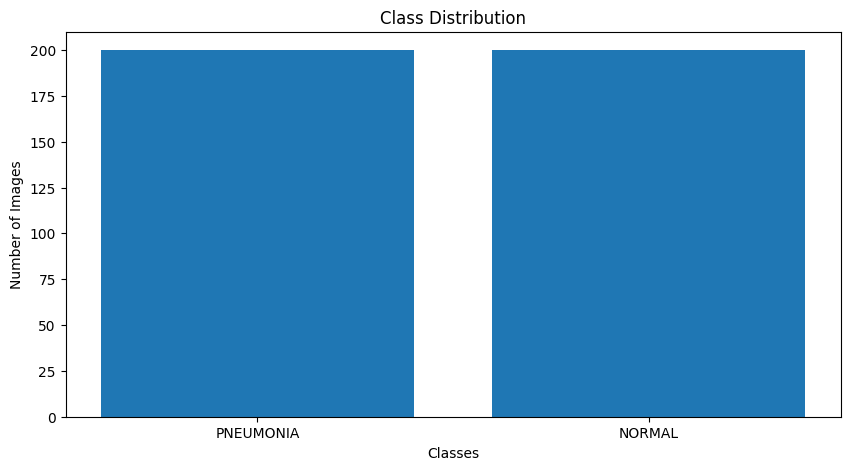

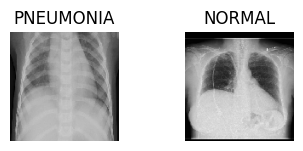

In [10]:
from collections import Counter

# Count images per class
class_counts = Counter()
for cls in classes:
    class_dir = os.path.join(image_dir, cls)
    class_counts[cls] = len(os.listdir(class_dir))

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

for i, cls in enumerate(classes, start=1):
    img_path = os.path.join(image_dir, cls, os.listdir(os.path.join(image_dir, cls))[0])
    img = load_img(img_path, target_size=(128, 128))
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()

In [11]:
class_labels = ['NORMAL', 'PNEUMONIA']
dataset = load_and_filter_images(image_dir, class_labels, img_size=(128, 128))

# Now you can batch, shuffle, and prefetch as needed
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_ds, val_ds = split_dataset(dataset)


2024-04-16 14:42:28.068201: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
model = Sequential([
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(2, activation='softmax')  # Changed to 2 for the two classes
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model3 = model
model3.summary()

/users/PCS0229/imankhazrak/miniconda3/envs/ddpm_pytorch/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,183,234 (65.55 MB)

 Trainable params: 17,182,338 (65.55 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 521ms/step - accuracy: 0.6138 - loss: 3.0547 - val_accuracy: 0.4583 - val_loss: 16.5400
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 462ms/step - accuracy: 0.9222 - loss: 0.9071 - val_accuracy: 0.4375 - val_loss: 12.3796
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 476ms/step - accuracy: 0.9079 - loss: 0.8668 - val_accuracy: 0.5625 - val_loss: 9.1959
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - accuracy: 0.9552 - loss: 0.8249 - val_accuracy: 0.6562 - val_loss: 5.1976
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - accuracy: 0.9843 - loss: 0.7126 - val_accuracy: 0.5469 - val_loss: 5.6561
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 462ms/step - accuracy: 0.9958 - loss: 0.6971 - val_accuracy: 0.3281 - val_loss: 4.1432
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - accuracy: 0.9742 - loss: 0.7265 - val_accuracy: 0.6094 - val_loss: 2.9813
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - accuracy: 0.9994 - loss: 0.6759 - val_accuracy: 

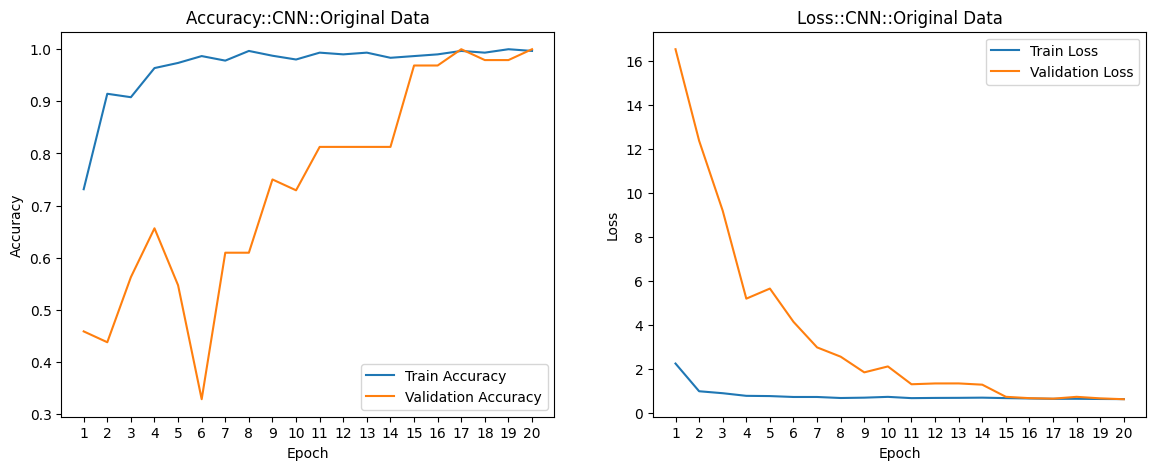

In [13]:
history3 = model3.fit(train_ds, epochs = 20, batch_size = 32, verbose = 1, validation_data = val_ds)
title = "Original Data"

model_name = "CNN"
plot_training_history2(history3, title, model_name, figsize=(14, 5))

In [14]:
test_dir = f'{path_dir}/DataDDPM/Test'

dataset_test = load_and_filter_images(test_dir, class_labels, img_size=(128, 128))

# Now you can batch, shuffle, and prefetch as needed
dataset_test = dataset_test.shuffle(buffer_size=1024).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = dataset_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


2024-04-16 14:44:25.320838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confusion matrix, without normalization
[[1483   99]
 [  99 1501]]
              precision    recall  f1-score   support

      NORMAL       0.94      0.94      0.94      1582
   PNEUMONIA       0.94      0.94      0.94      1600

    accuracy                           0.94      3182
   macro avg       0.94      0.94      0.94      3182
weighted avg       0.94      0.94      0.94      3182



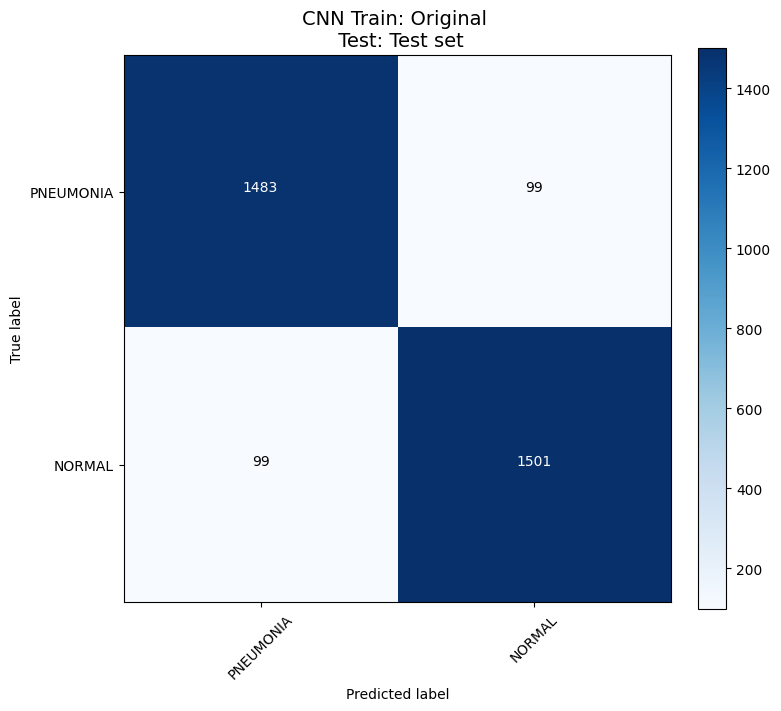

In [15]:
true_labels = np.array([])
pred_labels = np.array([])

for images, labels in test_ds:
    preds = model3.predict(images, verbose=0)
    true_labels = np.concatenate([true_labels, labels.numpy()])
    pred_labels = np.concatenate([pred_labels, np.argmax(preds, axis=1)])
    
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

cm = confusion_matrix(true_labels, pred_labels)

plot_confusion_matrix(cm, classes,
                      title='CNN Train: Original \n Test: Test set',
                      figsize=(8, 8),  # Adjust the figure size as needed
                      title_fontsize=14,
                      tick_labelsize=10,
                      colorbar_size={'shrink': 0.75, 'aspect': 20, 'pad': 0.04})
print(classification_report(true_labels, pred_labels, target_names=class_labels))


In [16]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

# For binary classification
binary_accuracy = accuracy_score(true_labels, pred_labels)
binary_recall = recall_score(true_labels, pred_labels)
binary_f1 = f1_score(true_labels, pred_labels)

print("Binary Classification:")
print(f"Accuracy: {binary_accuracy}")
print(f"Recall: {binary_recall}")
print(f"F1 Score: {binary_f1}")



Binary Classification:
Accuracy: 0.9377749842866122
Recall: 0.938125
F1 Score: 0.938125


## Train: Original & DDPM Data

In [17]:
image_dir_mixed  = f'{path_dir}/DataDDPM/Mixed'

class_labels = ['COVID', 'PNEUMONIA']
dataset_mixed = load_and_filter_images(image_dir_mixed, class_labels, img_size=(128, 128))

# Now you can batch, shuffle, and prefetch as needed
dataset_mixed = dataset_mixed.shuffle(buffer_size=1024).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_ds, val_ds = split_dataset(dataset_mixed)


In [18]:
model = Sequential([
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(2, activation='softmax')  # Changed to 2 for the two classes
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model4 = model
model4.summary()

/users/PCS0229/imankhazrak/miniconda3/envs/ddpm_pytorch/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,183,234 (65.55 MB)

 Trainable params: 17,182,338 (65.55 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.7988 - loss: 1.3256 - val_accuracy: 0.5125 - val_loss: 10.5304
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step - accuracy: 0.9575 - loss: 0.8167 - val_accuracy: 0.5750 - val_loss: 4.3787
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 485ms/step - accuracy: 0.9758 - loss: 0.7757 - val_accuracy: 0.8313 - val_loss: 1.2436
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 485ms/step - accuracy: 0.9678 - loss: 0.7759 - val_accuracy: 0.9312 - val_loss: 0.8589
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 485ms/step - accuracy: 0.9697 - loss: 0.7206 - val_accuracy: 0.9375 - val_loss: 0.8502
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 486ms/step - accuracy: 0.9842 - loss: 0.7037 - val_accuracy: 0.9875 - val_loss: 0.6738
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 486ms/step - accuracy: 0.9870 - loss: 0.6732 - val_accuracy: 0.9750 - val_loss: 0.6699
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 484ms/step - accuracy: 0.9930 - loss: 0.6510 - val_acc

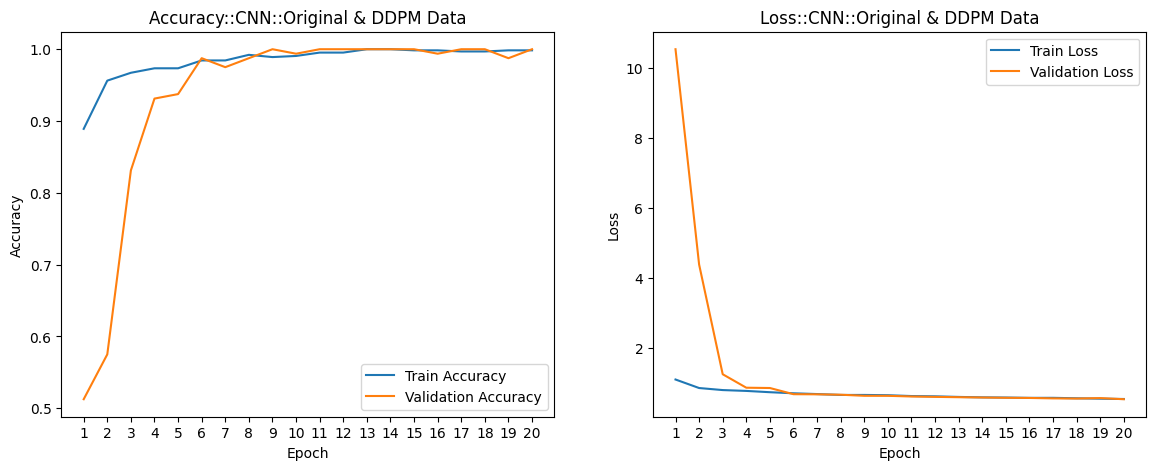

In [19]:
title = "Original & DDPM Data"
model_name = "CNN"
history4 = model4.fit(train_ds, epochs = 20, batch_size = 32, verbose = 1, validation_data = val_ds)
plot_training_history2(history4, title, model_name, figsize=(14, 5))

2024-04-16 14:48:04.417263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confusion matrix, without normalization
[[1378   48]
 [  33 1567]]
              precision    recall  f1-score   support

       COVID       0.98      0.97      0.97      1426
   PNEUMONIA       0.97      0.98      0.97      1600

    accuracy                           0.97      3026
   macro avg       0.97      0.97      0.97      3026
weighted avg       0.97      0.97      0.97      3026



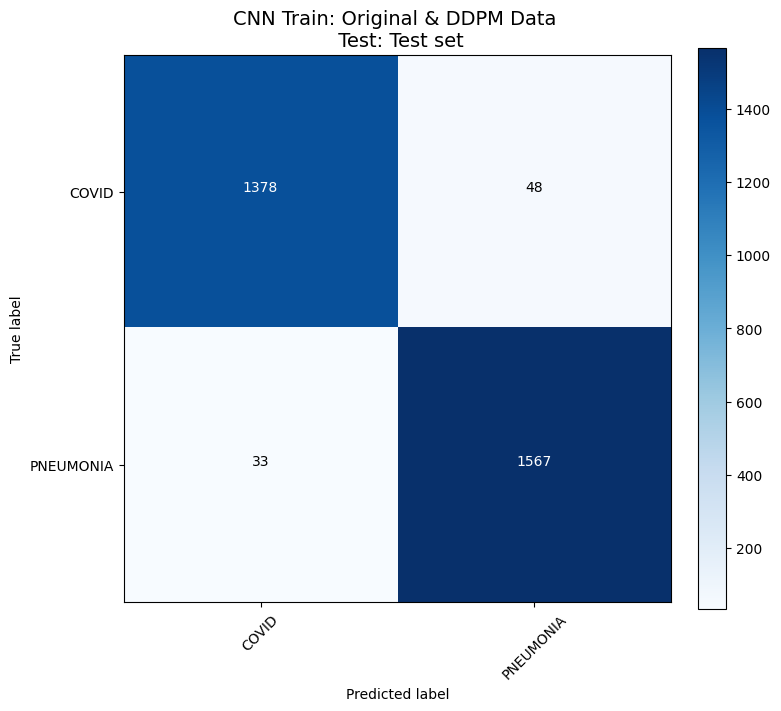

In [20]:
test_dir = f'{path_dir}/DataDDPM/Test'

dataset_test = load_and_filter_images(test_dir, class_labels, img_size=(128, 128))

# Now you can batch, shuffle, and prefetch as needed
dataset_test = dataset_test.shuffle(buffer_size=1024).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = dataset_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
true_labels = np.array([])
pred_labels = np.array([])

for images, labels in test_ds:
    preds = model4.predict(images, verbose=0)
    true_labels = np.concatenate([true_labels, labels.numpy()])
    pred_labels = np.concatenate([pred_labels, np.argmax(preds, axis=1)])
    
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

cm = confusion_matrix(true_labels, pred_labels)
classes = class_labels
plot_confusion_matrix(cm, classes,
                      title=f'CNN Train: Original & DDPM Data \n Test: Test set',
                      figsize=(8, 8),  # Adjust the figure size as needed
                      title_fontsize=14,
                      tick_labelsize=10,
                      colorbar_size={'shrink': 0.75, 'aspect': 20, 'pad': 0.04})

print(classification_report(true_labels, pred_labels, target_names=class_labels))


In [21]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

# For binary classification
binary_accuracy = accuracy_score(true_labels, pred_labels)
binary_recall = recall_score(true_labels, pred_labels)
binary_f1 = f1_score(true_labels, pred_labels)

print("Binary Classification:")
print(f"Accuracy: {binary_accuracy}")
print(f"Recall: {binary_recall}")
print(f"F1 Score: {binary_f1}")

Binary Classification:
Accuracy: 0.9732319894249835
Recall: 0.979375
F1 Score: 0.9748055987558321


## Train: Original & GANs Data

In [22]:
image_dir_mixed  = f'{path_dir}/DataGANS/Mixed'

class_labels = ['NORMAL', 'PNEUMONIA']
dataset_mixed = load_and_filter_images(image_dir_mixed, class_labels, img_size=(128, 128))

# Now you can batch, shuffle, and prefetch as needed
dataset_mixed = dataset_mixed.shuffle(buffer_size=1024).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_ds, val_ds = split_dataset(dataset_mixed)

In [23]:
model = Sequential([
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(2, activation='softmax')  # Changed to 2 for the two classes
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model5 = model
model5.summary()

/users/PCS0229/imankhazrak/miniconda3/envs/ddpm_pytorch/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,183,234 (65.55 MB)

 Trainable params: 17,182,338 (65.55 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step - accuracy: 0.6841 - loss: 1.9171 - val_accuracy: 0.5227 - val_loss: 8.3595
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - accuracy: 0.8545 - loss: 1.1074 - val_accuracy: 0.5417 - val_loss: 4.5592
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step - accuracy: 0.9101 - loss: 1.0023 - val_accuracy: 0.5312 - val_loss: 3.7166
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 471ms/step - accuracy: 0.9354 - loss: 0.8535 - val_accuracy: 0.4896 - val_loss: 3.3035
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 476ms/step - accuracy: 0.9807 - loss: 0.7255 - val_accuracy: 0.4659 - val_loss: 3.8338
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step - accuracy: 0.9862 - loss: 0.6989 - val_accuracy: 0.5521 - val_loss: 2.1675
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - accuracy: 0.9890 - loss: 0.6826 - val_accuracy: 0.5833 - val_loss: 1.6773
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 464ms/step - accuracy: 0.9852 - loss: 0.6929 - val_accuracy: 0

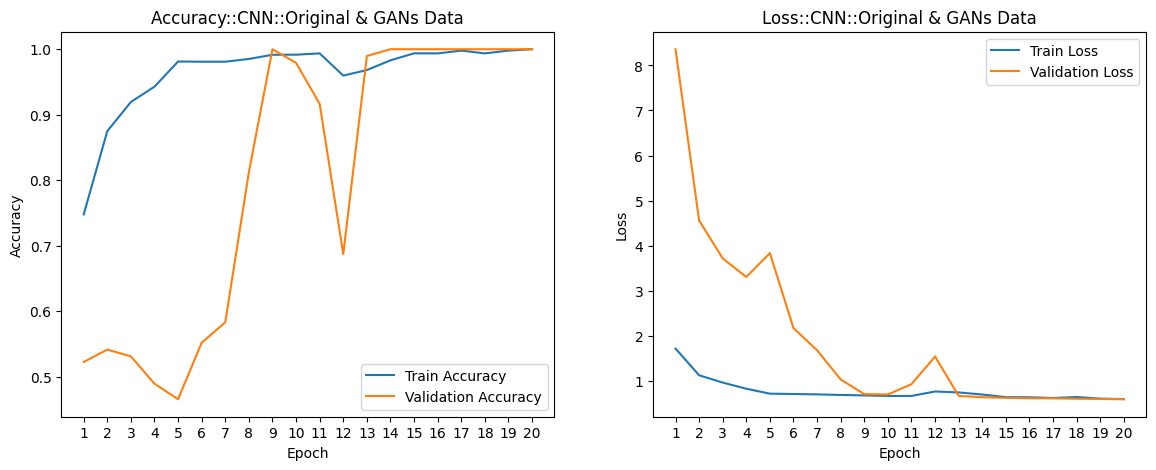

In [24]:
history5 = model5.fit(train_ds, epochs = 20, batch_size = 32, verbose = 1, validation_data = val_ds)
title = "Original & GANs Data"
plot_training_history2(history5, title, model_name, figsize=(14, 5))

2024-04-16 14:50:43.327949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confusion matrix, without normalization
[[ 718  708]
 [  44 1556]]
              precision    recall  f1-score   support

      NORMAL       0.94      0.50      0.66      1426
   PNEUMONIA       0.69      0.97      0.81      1600

    accuracy                           0.75      3026
   macro avg       0.81      0.74      0.73      3026
weighted avg       0.81      0.75      0.74      3026



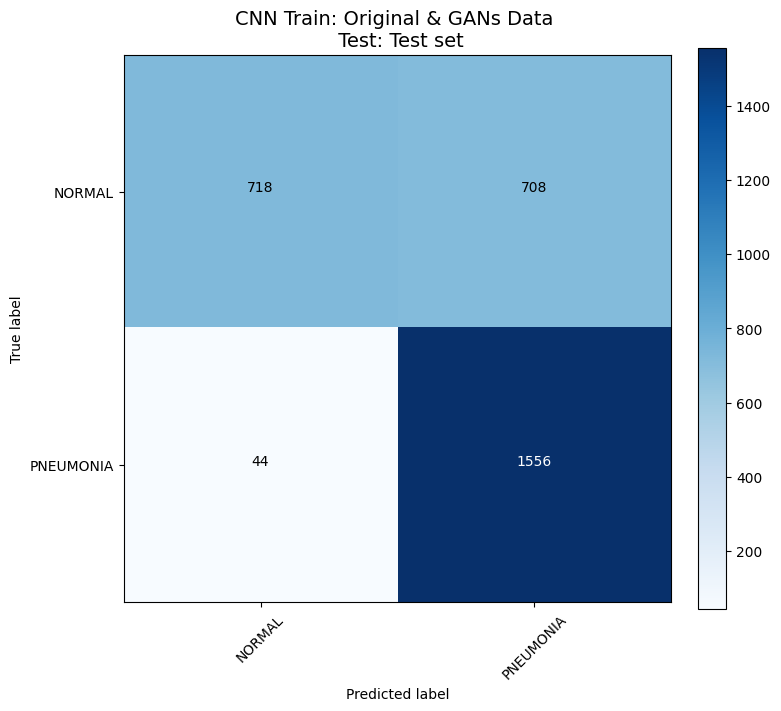

In [25]:
true_labels = np.array([])
pred_labels = np.array([])

for images, labels in test_ds:
    preds = model5.predict(images, verbose=0)
    true_labels = np.concatenate([true_labels, labels.numpy()])
    pred_labels = np.concatenate([pred_labels, np.argmax(preds, axis=1)])
    
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

cm = confusion_matrix(true_labels, pred_labels)
classes = class_labels
plot_confusion_matrix(cm, classes,
                      title=f'CNN Train: Original & GANs Data \n Test: Test set',
                      figsize=(8, 8),  # Adjust the figure size as needed
                      title_fontsize=14,
                      tick_labelsize=10,
                      colorbar_size={'shrink': 0.75, 'aspect': 20, 'pad': 0.04})

print(classification_report(true_labels, pred_labels, target_names=class_labels))


In [26]:
binary_accuracy = accuracy_score(true_labels, pred_labels)
binary_recall = recall_score(true_labels, pred_labels)
binary_f1 = f1_score(true_labels, pred_labels)

print("Binary Classification:")
print(f"Accuracy: {binary_accuracy}")
print(f"Recall: {binary_recall}")
print(f"F1 Score: {binary_f1}")

Binary Classification:
Accuracy: 0.751487111698612
Recall: 0.9725
F1 Score: 0.8053830227743272
